# Importons les bibliotehques necessaire

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV, StratifiedKFold
from sklearn import metrics, preprocessing
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Dense, BatchNormalization, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from pyDeepInsight import ImageTransformer, LogScaler
from keras.callbacks import EarlyStopping
import time

2023-11-12 18:35:06.042542: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Partie 1 : Analyse des donnees

In [3]:
df_ = pd.read_csv('../FlowStatsfile.csv')

In [3]:
df_.head()

,timestamp,datapath,flow_id,in_port,eth_type,eth_src,eth_dst,ip_src,tp_src,ip_dst,...,protocol,pktcount,bytecount,flowdur_sec,flowdur_nsec,pktcount_sec,pktcount_nsec,bytecount_sec,bytecount_nsec,label
0,1.699748e+09,2,172.24.16.260172.24.16.280,2,2048,02:a7:00:00:00:04,02:a7:00:00:00:01,172.24.16.26,0,172.24.16.28,...,ICMP,0,0,16,989000000,0.0,0.0,0.000000,0.0,0.0
1,1.699748e+09,2,172.24.16.270172.24.16.280,2,2048,02:a7:00:00:00:09,02:a7:00:00:00:01,172.24.16.27,0,172.24.16.28,...,ICMP,0,0,16,906000000,0.0,3.0643513789581205e-09,33.000000,2.0224719101123595e-07,0.0
2,1.699748e+09,2,172.24.16.280172.24.16.260,4,2048,02:a7:00:00:00:01,02:a7:00:00:00:04,172.24.16.28,0,172.24.16.26,...,ICMP,0,0,16,995000000,0.0,4.400440044004401e-09,108.166667,7.139713971397139e-07,0.0
3,1.699748e+09,2,172.24.16.280172.24.16.270,1,2048,02:a7:00:00:00:01,02:a7:00:00:00:09,172.24.16.28,0,172.24.16.27,...,ICMP,0,0,16,966000000,0.0,6.2015503875968995e-09,108.166667,1.0062015503875969e-06,0.0
4,1.699748e+09,5,172.24.16.260172.24.16.280,4,2048,02:a7:00:00:00:04,02:a7:00:00:00:01,172.24.16.26,0,172.24.16.28,...,ICMP,0,0,16,985000000,0.0,6.25e-08,54.714286,7.979166666666666e-06,0.0


In [7]:
df_.shape

(123165, 23)

In [5]:
df_.shape

(123165, 23)

In [10]:
df.label.unique()

array([ 0.,  1., nan])

In [9]:
df.label.value_counts()

0.0    64747
1.0    58405
Name: label, dtype: int64

In [8]:
df.protocol.value_counts()

TCP     45532
UDP     40867
ICMP    36766
Name: protocol, dtype: int64

In [9]:
df.isna().sum()

timestamp          0
datapath           0
flow_id            0
in_port            0
eth_type           0
eth_src            0
eth_dst            0
ip_src             0
tp_src             0
ip_dst             0
tp_dst             0
icmp_code          0
icmp_type          0
protocol           0
pktcount           0
bytecount          0
flowdur_sec        0
flowdur_nsec       0
pktcount_sec       0
pktcount_nsec     13
bytecount_sec     13
bytecount_nsec    13
label             13
dtype: int64

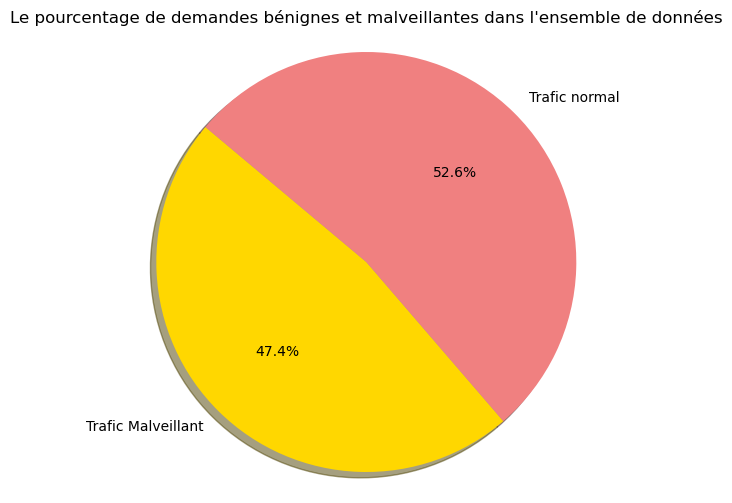

In [235]:
labels = ("Trafic Malveillant", "Trafic normal")
sizes = [len(df_[df_["label"]== 1]), len(df_[df_["label"]== 0])]

colors = ['gold', 'lightcoral']

plt.figure(figsize=(9, 6))
plt.title("Le pourcentage de demandes bénignes et malveillantes dans l'ensemble de données")

plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)

plt.axis('equal')

plt.show()

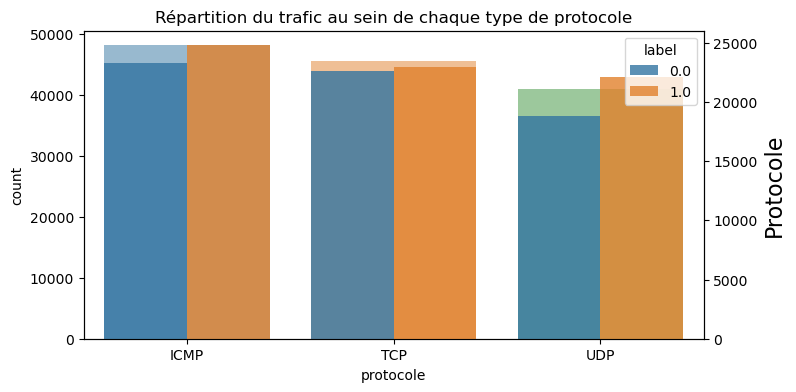

In [212]:
plt.figure(figsize=(8,4))
plt.title("Répartition du trafic au sein de chaque type de protocole")
g1 = sns.countplot(x='protocole', data=df_,alpha=0.5)
gt = g1.twinx()
gt = sns.countplot(x='protocole', hue='label',alpha=0.8, data=df_)
gt.set_ylabel('Protocole', fontsize=16)
plt.savefig('Protocole.png')

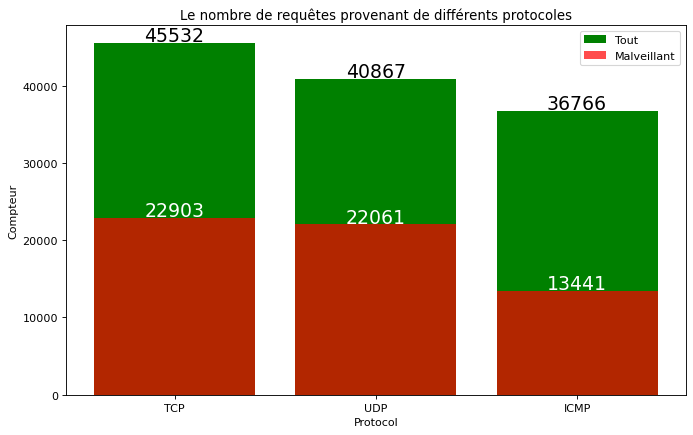

In [6]:
all_counts = df_['protocol'].value_counts().tolist()
malicious_counts = df_[df_['label'] == 1]['protocol'].value_counts().tolist()
protocols = df_['protocol'].value_counts().index.tolist()


fig, ax = plt.subplots(figsize=(10, 6), dpi=80)
bar1 = ax.bar(protocols, all_counts, color='g', label='Tout')
bar2 = ax.bar(protocols, malicious_counts, color='r', label='Malveillant', alpha=0.7)
#bar3 = ax.bar(protocols, normal_counts, color='b', label='Normal', alpha=0.5)

for i, bar in enumerate(bar1):
    ax.text(bar.get_x() + bar.get_width() / 2 - 0.15, bar.get_height() + 200, str(all_counts[i]), color='black', size=17)

for i, bar in enumerate(bar2):
    ax.text(bar.get_x() + bar.get_width() / 2 - 0.15, bar.get_height() + 200, str(malicious_counts[i]), color='w', size=17)

ax.set_xlabel('Protocol')
ax.set_ylabel('Compteur')
ax.legend()
ax.set_title('Le nombre de requêtes provenant de différents protocoles')
plt.savefig('Protocol.png')
#plt.show()

Text(0.5, 1.0, 'Durée de flux par second')

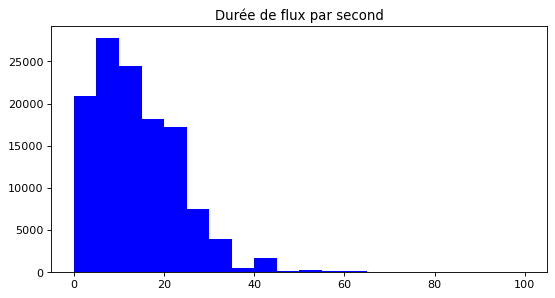

In [237]:
plt.figure(figsize=(8, 4), dpi=80)
plt.hist(df_.flowdur_sec, bins=20, color='b')
plt.title('Durée de flux par second')
#plt.savefig("Duree_S.png")

In [ ]:
plt.figure(figsize=(8, 4), dpi=80)
plt.hist(df_.flowdur_nsec, bins=25, color='g')
plt.title('Durée de flux par nanosecond')
#plt.savefig("Duree_Ns.png")

# Partie 2 : Prétraitement des données

## Suppressions de toutes les informations inutiles

In [3]:
df_.dropna(inplace=True)
df_.drop(['timestamp','datapath','flow_id','in_port','eth_type','eth_src', 'eth_dst', 'ip_src', 'ip_dst'], axis=1, inplace=True)

## Créons des variables factices pour la colonne Protocole

In [4]:
df_.info()
df_.protocol.unique()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 123152 entries, 0 to 123164
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   tp_src          123152 non-null  int64  
 1   tp_dst          123152 non-null  int64  
 2   icmp_code       123152 non-null  int64  
 3   icmp_type       123152 non-null  int64  
 4   protocol        123152 non-null  object 
 5   pktcount        123152 non-null  int64  
 6   bytecount       123152 non-null  int64  
 7   flowdur_sec     123152 non-null  int64  
 8   flowdur_nsec    123152 non-null  int64  
 9   pktcount_sec    123152 non-null  float64
 10  pktcount_nsec   123152 non-null  float64
 11  bytecount_sec   123152 non-null  float64
 12  bytecount_nsec  123152 non-null  float64
 13  label           123152 non-null  float64
dtypes: float64(5), int64(8), object(1)
memory usage: 14.1+ MB


array(['ICMP', 'TCP', 'UDP'], dtype=object)

In [5]:
df_dummies = pd.get_dummies(df_['protocol'])
df_ = pd.concat([df_, df_dummies], axis=1)

In [6]:
df_.head()

,tp_src,tp_dst,icmp_code,icmp_type,protocol,pktcount,bytecount,flowdur_sec,flowdur_nsec,pktcount_sec,pktcount_nsec,bytecount_sec,bytecount_nsec,label,ICMP,TCP,UDP
0,0,0,0,0,ICMP,0,0,16,989000000,0.0,0.000000e+00,0.000000,0.000000e+00,0.0,1,0,0
1,0,0,0,0,ICMP,0,0,16,906000000,0.0,3.064351e-09,33.000000,2.022472e-07,0.0,1,0,0
2,0,0,0,8,ICMP,0,0,16,995000000,0.0,4.400440e-09,108.166667,7.139714e-07,0.0,1,0,0
3,0,0,0,8,ICMP,0,0,16,966000000,0.0,6.201550e-09,108.166667,1.006202e-06,0.0,1,0,0
4,0,0,0,0,ICMP,0,0,16,985000000,0.0,6.250000e-08,54.714286,7.979167e-06,0.0,1,0,0


In [7]:
df_["classe"] = df_["label"]
del df_["label"]
del df_["protocol"]

In [8]:
df_.head()

,tp_src,tp_dst,icmp_code,icmp_type,pktcount,bytecount,flowdur_sec,flowdur_nsec,pktcount_sec,pktcount_nsec,bytecount_sec,bytecount_nsec,ICMP,TCP,UDP,classe
0,0,0,0,0,0,0,16,989000000,0.0,0.000000e+00,0.000000,0.000000e+00,1,0,0,0.0
1,0,0,0,0,0,0,16,906000000,0.0,3.064351e-09,33.000000,2.022472e-07,1,0,0,0.0
2,0,0,0,8,0,0,16,995000000,0.0,4.400440e-09,108.166667,7.139714e-07,1,0,0,0.0
3,0,0,0,8,0,0,16,966000000,0.0,6.201550e-09,108.166667,1.006202e-06,1,0,0,0.0
4,0,0,0,0,0,0,16,985000000,0.0,6.250000e-08,54.714286,7.979167e-06,1,0,0,0.0


In [9]:
df_.shape

(123152, 16)

## Appliquons une échelle MinMax pour normaliser notre ensemble de données et faire en sorte que toutes les valeurs soient comprises dans l'intervalle (0,1).

In [10]:
scaler = preprocessing.MinMaxScaler()

In [11]:
df_std= scaler.fit_transform(df_)
df_std

array([[0.        , 0.        , 0.01123596, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.01123596, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.01123596, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.01123596, ..., 0.        , 0.        ,
        1.        ],
       [0.        , 0.        , 0.01123596, ..., 0.        , 0.        ,
        1.        ],
       [0.        , 0.        , 0.01123596, ..., 0.        , 0.        ,
        1.        ]])

In [12]:
new_df = pd.DataFrame(df_std, columns=df_.columns)
new_df.head()

,tp_src,tp_dst,icmp_code,icmp_type,pktcount,bytecount,flowdur_sec,flowdur_nsec,pktcount_sec,pktcount_nsec,bytecount_sec,bytecount_nsec,ICMP,TCP,UDP,classe
0,0.0,0.0,0.011236,0.011236,0.0,0.0,0.16,0.989990,0.0,0.000000e+00,0.000000e+00,0.000000e+00,1.0,0.0,0.0,0.0
1,0.0,0.0,0.011236,0.011236,0.0,0.0,0.16,0.906907,0.0,1.070276e-08,1.073652e-08,1.612217e-11,1.0,0.0,0.0,0.0
2,0.0,0.0,0.011236,0.101124,0.0,0.0,0.16,0.995996,0.0,1.536928e-08,3.519194e-08,5.691436e-11,1.0,0.0,0.0,0.0
3,0.0,0.0,0.011236,0.101124,0.0,0.0,0.16,0.966967,0.0,2.165996e-08,3.519194e-08,8.020954e-11,1.0,0.0,0.0,0.0
4,0.0,0.0,0.011236,0.011236,0.0,0.0,0.16,0.985986,0.0,2.182918e-07,1.780125e-08,6.360607e-10,1.0,0.0,0.0,0.0


## Divisons notre ensemble de données en variables d'entrée X et de sortie Y.

In [13]:
X = new_df.iloc[:,1:17].astype(float)
y = new_df.iloc[:,-1]

## Divisons notre ensemble de données en un ensemble de formation (80 %) et un ensemble de test (20 %).

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [15]:
new_df.shape

(123152, 16)

In [16]:
# Créez un modèle séquentiel
model = Sequential()

# Couche d'entrée
model.add(Dense(128, input_shape=(15,), activation='relu'))

# Couches cachées profondes
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Couche de sortie
model.add(Dense(1, activation='sigmoid'))

# Compilez le modèle
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Résumé du modèle
model.summary()


2023-11-12 17:14:44.261231: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-12 17:14:44.266359: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               2048      
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 512)               131584    
                                                                 
 batch_normalization_1 (Batc  (None, 512)              2048      
 hNormalization)                                        

In [17]:
# Ce rappel arrêtera la formation lorsqu'il n'y aura pas d'amélioration de la perte de validation pendant 5 époques consécutives.  
es = EarlyStopping(
    monitor='val_accuracy', 
    mode='max',
    patience=5,
    restore_best_weights=True
)

In [18]:
model.compile(loss='binary_crossentropy', 
              optimizer='Adam', 
              metrics=['accuracy'])

In [ ]:
model.fit(X_train, 
          y_train, 
          epochs=30,
          batch_size=255, 
          verbose=1, 
          validation_split=0.2,
          callbacks=[es])

Epoch 1/30
310/310 [==============================] - 20s 59ms/step - loss: 0.0116 - accuracy: 0.9954 - val_loss: 0.0076 - val_accuracy: 1.0000
Epoch 2/30
310/310 [==============================] - 17s 54ms/step - loss: 1.7627e-04 - accuracy: 1.0000 - val_loss: 1.7309e-05 - val_accuracy: 1.0000
Epoch 3/30
310/310 [==============================] - 15s 48ms/step - loss: 7.3406e-05 - accuracy: 1.0000 - val_loss: 2.0980e-06 - val_accuracy: 1.0000
Epoch 4/30
310/310 [==============================] - 16s 52ms/step - loss: 4.2488e-05 - accuracy: 1.0000 - val_loss: 1.3000e-06 - val_accuracy: 1.0000
Epoch 5/30
310/310 [==============================] - 14s 45ms/step - loss: 2.7527e-05 - accuracy: 1.0000 - val_loss: 7.5880e-07 - val_accuracy: 1.0000
Epoch 6/30
290/310 [===========================>..] - ETA: 1s - loss: 2.2908e-05 - accuracy: 1.0000

In [ ]:
history_dict = model.history.history

In [ ]:
# loss
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(loss_values) + 1) 

# plot
plt.figure(figsize=(9, 4))
plt.plot(epochs, loss_values, 'blue',label='Training loss')
plt.plot(epochs, val_loss_values, 'green', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
     

In [ ]:
results = model.evaluate(X_test, y_test, batch_size=250)
print("Test set accuracy = {} %".format( results[1]*100))

In [ ]:
preds = np.round(model.predict(X_test),0)

print(confusion_matrix(y_test, preds)) 

### 1. Modèle de régression logistique

In [ ]:
# Paramètres du modèle
C_value = 0.03
solvers = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']

results_lr = []

start_time = time.time()
best_accuracy = 0
best_solver = None

for solver in solvers:
    # Entraînement du modèle
    logreg_model = LogisticRegression(C=C_value, solver=solver).fit(X_train, y_train)
    predicted_lr = logreg_model.predict(X_test)
    accuracy_lr = accuracy_score(y_test, predicted_lr)
    
    results_lr.append({
        'solver': solver,
        'accuracy': f'{accuracy_lr * 100:.2f}%',
        'coefficients': {'W': logreg_model.coef_, 'b': logreg_model.intercept_}
    })

    if accuracy_lr > best_accuracy:
        best_accuracy = accuracy_lr
        best_solver = solver

# Entraînement final avec le meilleur solveur
logreg_model = LogisticRegression(C=C_value, solver=best_solver).fit(X_train, y_train)
predicted_lr = logreg_model.predict(X_test)
accuracy_lr = accuracy_score(y_test, predicted_lr)

# Affichage des résultats
print(f"Précision: {accuracy_lr * 100:.2f}%\n")
print("########################################################################")
print('Meilleur solveur :', best_solver)
print("########################################################################")
print(classification_report(predicted_lr, y_test), '\n')
print("########################################################################")
print(f"--- {time.time() - start_time:.2f} secondes --- temps pour la régression logistique")


### 2. Modèle d'arbre de décision avec recherche des meilleurs hyperparamètres

In [ ]:
start_time = time.time()
dt_classifier = DecisionTreeClassifier()

# Recherche des hyperparamètres optimaux
param_grid = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_depth': [None, 2, 3, 4, 5],
    'max_leaf_nodes': [2, 3, 4, 5]
}

dt_search = GridSearchCV(dt_classifier, param_grid=param_grid, n_jobs=-1, cv=5, scoring='accuracy', verbose=2)
dt_search.fit(X_train, y_train)

criterion = dt_search.best_params_['criterion']
max_depth = dt_search.best_params_['max_depth']
max_leaf_nodes = dt_search.best_params_['max_leaf_nodes']

# Entraînement du modèle avec les hyperparamètres optimaux
dt_classifier = DecisionTreeClassifier(criterion=criterion, max_depth=max_depth, max_leaf_nodes=max_leaf_nodes)
dt_classifier.fit(X_train, y_train)

# Prédiction et évaluation du modèle
predicted_dt = dt_classifier.predict(X_test)
accuracy_dt = accuracy_score(y_test, predicted_dt)

# Stockage des résultats
results = {
    'criterion': criterion,
    'max_depth': max_depth,
    'max_leaf_nodes': max_leaf_nodes,
    'accuracy': round(accuracy_dt * 100, 2)
}

# Affichage des résultats
print(f"criterion: {criterion}, max depth: {max_depth}, max_leaf: {max_leaf_nodes}")
print(f"La précision est : {results['accuracy']}%")
print("########################################################################")
print(classification_report(predicted_dt, y_test))
print("########################################################################")

print("--- %s secondes --- temps pour l'arbre de décision " % (time.time() - start_time))

### 3. Forêt aléatoire

In [ ]:
start_time = time.time()

# Définissez la grille d'hyperparamètres à explorer
param_grid = {
    'criterion': ['gini'],
    'n_estimators': [100],
    'max_depth': [None],
    'min_samples_split': [2],
    'max_features': ['sqrt']
}

# Créez le modèle RandomForestClassifier
rf_classifier = RandomForestClassifier()

# Utilisez GridSearchCV pour trouver les meilleurs hyperparamètres
grid_search = GridSearchCV(rf_classifier, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Obtenir les meilleurs hyperparamètres trouvés
best_params = grid_search.best_params_

# Entraînez un modèle RandomForest avec les meilleurs hyperparamètres
rf_classifier_best = RandomForestClassifier(criterion='gini', oob_score=True, random_state=1, n_jobs=-1, **best_params)
rf_classifier_best.fit(X_train, y_train)

# Prédisez les étiquettes
predicted_rf = rf_classifier_best.predict(X_test)
accuracy_rf = accuracy_score(y_test, predicted_rf)

# Affichage des résultats
print(f"Random Forest Précision: {round(accuracy_rf * 100, 2)}%")
print(f"Meilleurs hyperparamètres : {best_params}")
print(classification_report(predicted_rf, y_test))
#print(f"Time for Random Forest: {time.time() - start_time} seconds")
print("--- %s secondes --- temps pour le Random Forest " % (time.time() - start_time))

### 4. K-Nearest Neighbors (KNN)

In [ ]:
start_time = time.time()

# Création d'une liste de valeurs de k à tester
Ks = range(1, 13)

# Initialisation des tableaux pour stocker les résultats
accuracy_knn = np.zeros(len(Ks))

# Boucle sur les différentes valeurs de k
for i, k in enumerate(Ks):
    
    knn_classifier = KNeighborsClassifier(n_neighbors=k)
    
    knn_classifier.fit(X_train, y_train)
    
    yhat = knn_classifier.predict(X_test)
    
    accuracy_knn[i] = accuracy_score(y_test, yhat)

# Recherche des meilleurs hyperparamètres avec GridSearchCV
param_grid = {
    'n_neighbors': [3, 5, 10],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

# Création de l'objet GridSearchCV
knn_grid_search = GridSearchCV(KNeighborsClassifier(), param_grid=param_grid, cv=3, n_jobs=-1, scoring='accuracy', verbose=2)
knn_grid_search.fit(X_train, y_train)
best_params = knn_grid_search.best_params_

# Création du modèle k-NN avec les meilleurs hyperparamètres
best_knn = KNeighborsClassifier(**best_params)
best_knn.fit(X_train, y_train)
predicted_knn = best_knn.predict(X_test)
accuracy_knn = accuracy_score(y_test, predicted_knn)

# Affichage des résultats
print(f"Précision du modèle k-NN : {round(accuracy_knn * 100, 2)}%")
print("Meilleurs hyperparamètres:", best_params)
print(classification_report(predicted_knn, y_test))
print("--- %s secondes --- temps pour le modèle k-NN" % (time.time() - start_time))


In [ ]:
start_time = time.time()
Ks = 12
accuracy_knn = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))

for n in range(1, Ks):
    # Train Model and Predict
    neigh = KNeighborsClassifier(n_neighbors=n)
    neigh.fit(X_train, y_train)
    yhat = neigh.predict(X_test)
    accuracy_knn[n-1] = accuracy_score(y_test, yhat)
    std_acc[n-1] = np.std(yhat == y_test) / np.sqrt(yhat.shape[0])


# Optimization of k-NN hyperparameters using GridSearchCV
knnc = KNeighborsClassifier()
param_grid = {
    'n_neighbors': [3, 5, 10],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

knnc_search = GridSearchCV(knnc, param_grid=param_grid, n_jobs=-1, cv=3, scoring='accuracy', verbose=2)
knnc_search.fit(X_train, y_train)

best_params = knnc_search.best_params_
n_neighbors = best_params['n_neighbors']
weights = best_params['weights']
metric = best_params['metric']

KNN = KNeighborsClassifier(n_neighbors=n_neighbors, metric=metric, weights=weights)
KNN.fit(X_train, y_train)

predicted_knn = KNN.predict(X_test)
accuracy_knn = accuracy_score(y_test, predicted_knn)

# Display results
print(f"Précision du model KNN : {round(accuracy_knn * 100, 2)}%")
print("Meilleur hyperparameters:", best_params)
print(classification_report(predicted_knn, y_test))
#print("--- %s seconds ---" % (time.time() - start_time))
print("--- %s secondes --- temps pour le KNN model " % (time.time() - start_time))


### SVM

In [ ]:

start_time = time.time()

kernels = ['linear', 'poly', 'rbf', 'sigmoid']

# Liste pour stocker les précisions pour chaque noyau
accuracy_list = []

for kernel in kernels:
    # Création du modèle SVM avec le noyau actuel
    SVM = svm.SVC(kernel=kernel)

    # Entraînement du modèle
    SVM.fit(X_train, y_train)

    # Prédiction sur les données de test
    predicted_svm = SVM.predict(X_test)

    # Calcul de la précision
    accuracy_svm = accuracy_score(y_test, predicted_svm)

    # Ajout de la précision à la liste
    accuracy_list.append(accuracy_svm)

    # Affichage de la précision
    print(f"Précision du noyau {kernel} : {round(accuracy_svm * 100, 2)}%")
    print('#######################################################################')

# Sélection du meilleur noyau en fonction de la précision maximale
best_kernel = kernels[np.argmax(accuracy_list)]

# Entraînement final avec le meilleur noyau
best_SVM = svm.SVC(kernel=best_kernel)
best_SVM.fit(X_train, y_train)

# Prédiction avec le modèle optimal
predicted_svm = best_SVM.predict(X_test)

# Calcul de la précision
accuracy_svm = accuracy_score(y_test, predicted_svm)

# Affichage des résultats finaux
print(f"Précision du modèle SVM avec le meilleur noyau (noyau {best_kernel}): {round(accuracy_svm * 100, 2)}%")
print("########################################################################")
print('Le meilleur noyau est:', best_kernel)
print("########################################################################")
print(classification_report(y_test, predicted_svm))
print("########################################################################")
print("--- %s seconds --- temps pour le model SVM" % (time.time() - start_time))